# Edge Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
import imutils
from fastai.vision import *
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import sys
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from IPython.display import clear_output
import time
import bisect as bi
import IPython.display as disp

from helper_functions import *

In [3]:
path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_trained_model = path/'vocal_cords_and_rings_data/data/models'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

DEBUG_MODE = False

## Set up learner

In [4]:
learn = load_learner(path_trained_model, 'stage-2-big-0614-rn101.pkl')

In [5]:
def inference(frame):
    '''
    All the steps, one by one:
    
    frame_rgb = frame[...,::-1] #convert bgr to rgb

    t = Image(pil2tensor(PIL.Image.fromarray(frame_rgb).convert("RGB"), np.float32).div_(255))
    prediction = learn.predict(t)
    p = prediction[1].squeeze() #prediction data

    mask = np.array(p).astype(np.uint8)
    '''
    return np.array(
        learn.predict(Image(pil2tensor(PIL.Image.fromarray(frame[...,::-1]).convert("RGB"), np.float32).div_(255)))[1].squeeze()
        ).astype(np.uint8)

def unwrap_image(mask):
    
    ####### Find centroid of bifurcation#####
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    labels = get_blobs(mask,imshow=False)
    thresh = labels[3]
    thresh = img_as_uint(thresh*100)

    if len(np.where( thresh > 0 )[0]):
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 125
        cY = 150
        
    ###### endof find centre ############
    
    value = np.sqrt(((mask.shape[0]/2.0)**2.0)+((mask.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(mask.astype(np.float32),(cX,cY), value, cv2.WARP_FILL_OUTLIERS).astype(np.uint8)[:,:,0]
    
    return polar_image

def find_posterior_region(mask, prev_posterior_angles=None, posterior_region_ctr=0):
    if len(mask.shape)>2:
        raise Exception('Mask should be grayscale image.')
    
    posterior_region_ctr+=1
    
    # Find anterior and posterior parts of trachea
    histogram = np.sum((mask==1).astype(np.uint8), axis=1)#row-wise sums
    region, posterior_angle = longest_contiguous_region(histogram < 5, histogram)
    
    if prev_posterior_angles is not None:
        #Average previous angles
        prev_posterior_angles[posterior_region_ctr%len(prev_posterior_angles)]=posterior_angle
        posterior = int(np.average(prev_posterior_angles))
        
        return posterior, prev_posterior_angles, posterior_region_ctr

    return posterior_angle, None, None

def get_posterior_corrected_frame(mask, posterior):
    temp = mask[0:posterior,0:]
    return np.concatenate((mask[posterior:,0:],temp))

In [6]:
class Tracker():
    
    def __init__(self, init_frame=None, _verbose=False):
        self.mid_blob_tracks = []
        self.mid_prev=[]
        self.verbose=_verbose
        mask_continuous=init_frame

        blobs_prev = get_blobs_single_class(mask_continuous==1, label_value=255)
        
        self.mid_blob_tracks = []
        for m in blobs_prev:
            if blob_area(m[112:122:])>0:
                M = cv2.moments((m[112:122:]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])
                self.mid_blob_tracks.append([cX])
        self.mid_blob_tracks.sort(reverse=True)
        mid_temp = get_middle_section(blobs_prev, collapse_channels=False)
        
        self.mid_prev=[]
        for mid in mid_temp:
            if blob_area(mid)>0:
                self.mid_prev.append(mid)
    
    def iterate(self, new_frame, ring_value=1):
        img = new_frame==ring_value
        
        #Find all blobs in current frame
        blobs_current = get_blobs_single_class(img, label_value=255)
        mid_temp = get_middle_section(blobs_current, collapse_channels=False)
        mid_new = []
        for mid in mid_temp:
            if blob_area(mid)>0:
                mid_new.append(mid)
                
        #Correlate children to parent blobs
        # blobs_new has the joined blobs with indices corresponding to their parents
        blobs_new, orphans = correlate_blobs(mid_new, self.mid_prev, orphan_min_area=50)
        if blobs_new is None:
            if DEBUG_MODE:
                print("EMPTY!!")
        
        #Add orphans to blobs_prev, so they can become parents in the next iteration
        #Note: this happens AFTER children have already found their parents
        self.mid_prev = []
        for blob_ in blobs_new:
            if blob_area(blob_[0])>0:
                self.mid_prev.append(blob_[0])
                
        if DEBUG_MODE:        
            #debug check
            for en, bl in enumerate(self.mid_prev):
                if blob_area(bl)<1:
                    print("Empty blob at mid_prev[{}]".format(en))

        orphan_imgs = [np.array(o[0]).astype(np.uint8) for o in orphans]
        for o in orphan_imgs:
            if blob_area(o)>0:
                 self.mid_prev.append(o)
        
        for ctr,m in enumerate(blobs_new):
            M_prev = cv2.moments((m[1]>0).astype(np.uint8))
            cX_prev = int(M_prev["m10"] / M_prev["m00"])
            last_values = [track[-1] for track in self.mid_blob_tracks]

            if blob_area(m[0])>0: #non-empty child
                M = cv2.moments((m[0]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])        

                if cX_prev not in last_values:
                    raise Exception('Bad correlation. Parent not in list')

                self.mid_blob_tracks[last_values.index(cX_prev)].append(cX)
            else:#child is empty
                if DEBUG_MODE: print("{} NO CHILD.".format(ctr))
                self.mid_blob_tracks[last_values.index(cX_prev)].append(None)
                
        #Insert at beginning (right-most blobs)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        try:
            start_none, end_none = get_non_None_section(last_values)
        except Exception as e:
            if hasattr(e, 'message'):
                print(e.message)
            else:
                print(e)
            #Return out of iterate() indicating failed tracking
            return False
            
        right_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) > last_values[start_none])

        for cX in right_orphans:
            last_values = [track[-1] for track in self.mid_blob_tracks]
            for j, val in enumerate(last_values):
                if val is not None:
                    if j==0 and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks = [[cX]] + self.mid_blob_tracks
                        break
                    elif j!=0 and self.mid_blob_tracks[j-1][-1] is None and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks[j-1].append(cX)
                    #break is intentionally outside of elif
                    break
        #Insert at end (left-most blobs)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        left_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[end_none])
        left_orphans.reverse()

        for cX in left_orphans:
            last_values = [track[-1] for track in self.mid_blob_tracks]
            for j, val in enumerate(reversed(last_values)):
                ctr = len(last_values)-1-j
                if val is not None:
                    if ctr==len(last_values)-1 and cX < self.mid_blob_tracks[ctr][-1]: #i.e. last element in un-reversed last_values)
                        self.mid_blob_tracks = self.mid_blob_tracks+[[cX]]
                        break

                    elif ctr!=len(last_values)-1 and self.mid_blob_tracks[ctr+1][-1] is None and cX < self.mid_blob_tracks[ctr][-1]:
                        self.mid_blob_tracks[ctr+1].append(cX)
                    #break is intentionally outside of elif
                    break
                    
        #Must remove None islands before inserting a centre blob into tracks
        last_values = [track[-1] for track in self.mid_blob_tracks] #THIS ONE IS NEW - CHECK THAT IT WORKS IF NOT REMOVE LINE
        start_none, end_none = get_non_None_section(last_values)
        temp_tracks=[]
        idx_is_none = [val is None for val in [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]]
        for j,val in enumerate(idx_is_none):
            if val is False:
                temp_tracks=temp_tracks+[self.mid_blob_tracks[j+start_none]]
        self.mid_blob_tracks = self.mid_blob_tracks[:start_none]+temp_tracks+self.mid_blob_tracks[end_none+1:]

        #Insert at centre (in between other blobs in frame)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        centre_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[start_none] and get_centroid_x(o[0]) > last_values[end_none])
        
        for cX in centre_orphans:
            last_values = [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]
            # Must reverse list for insort to work properly (i.e. insort requires low to hi sorted)
            last_values.reverse()
            bi.insort(last_values, cX)
            last_values.reverse()
            idx = last_values.index(cX)+start_none
            self.mid_blob_tracks=self.mid_blob_tracks[:idx]+[[cX]]+self.mid_blob_tracks[idx:]
            
        if self.verbose:
            last_values = [track[-1] for track in self.mid_blob_tracks]
            plot_blobs_in_order([b[0] for b in blobs_new if blob_area(b[0])>0],blobs_current,last_values,plot=True)
        
            fig=plt.figure(figsize=(24,24))
            columns = 3
            rows = 1
            
            imgs = [intersect,img, img-intersect]
            for i in range(1, columns*rows +1):
                fig.add_subplot(rows, columns, i)
                plt.imshow(imgs[i-1])
            plt.show()
            
        return True #successful tracking

In [7]:
def correlate_blobs(new_blobs, prev_blobs, percent_overlap_thresh=0.75, child_area_thresh=1.5, orphan_min_area=50):
    """
    Link parent blobs from prev_blobs to children blobs from new_blobs
    constraints:

    0) children can only have one parent. parents can have multiple children

    1) children must have a large enough intersection with their parent

    2) children must be smaller than their parents (they are allowed to be larger up to a certain threshold)
    if a potential child has a strong correlation to a given potential parent (large intersection), it is only
    considered a child if child_area < parent_area*thresh (where thresh is >= 1)
    else if a potential child has a strong correlation to a given potential parent, and it doesn't meet the area criteria,
    a new track is created for it and it is parentless (TODO: consider going "back" in the tree and grouping previous blobs
    and considering them as a single blob so that the area criteria is met. rn thinking not needed)

    Args:
        new_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in current 
                   frame (see get_blobs_single_class() )
        prev_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in previous
                   frame (see get_blobs_single_class() )
        percent_overlap_thresh (default: 0.75): minimum amount that
                   child must overlap with parent to be considered
                   a child
        child_area_thresh (default: 1.5): child can be up to
                   child_area_thresh times bigger than its parent
                   to be considered a child
        orphan_min_area (default: 50): minimum area for a parentless
                   blob to be added to orphan list. All orphans with
                   less than orphan_min_area will be disregarded
                   
    Returns:
        family, orphans
        
        family: list of tuples of (child_blob, parent_blob) i.e. the
                actual frames are tuple[0] and tuple[1]
                If a parent has no children, entry will be (zero_arr, parent_blob)
                len of family is num_parent_blob
                
        orphans: list of tuples of (orphan_blob, None) i.e. the actual
                frame is tuple[0], and tuple[1] is None
                len of orphans is the number of orphans in current frame
                   
    """
    parent_to_children = {} #key is the parent ID, value is the child ID
    orphans = [] # IDs of blobs without parents
    
    #Make all children empty lists
    for p in range(0, len(prev_blobs)):
        parent_to_children[p] = [] 
    
    #Populate parent_to_child dict (children pick their parents)
    for c in range(0, len(new_blobs)):
        nblob = new_blobs[c]
   
        max_intercept = 0
        max_intercept_p = -1
                        
        for p in range(0,len(prev_blobs)):
            pblob = prev_blobs[p]
            intersect = cv2.bitwise_and(nblob, pblob)
            
            if blob_area(intersect) > max_intercept:
                max_intercept = blob_area(intersect)
                max_intercept_p = p
          
        if max_intercept > 0 and blob_area(nblob) < blob_area(prev_blobs[max_intercept_p])*child_area_thresh and max_intercept > blob_area(nblob)*0.10:
            parent_to_children[max_intercept_p].append(c) #Huzzah! Child picked a parent
#             print("nparents {} -child {} picked {} ".format(len(prev_blobs), c, max_intercept_p))
        else: #Child has no parent
            orphans.append(c)
                    
    #Join children blobs (if they belong to the same parent) to deal with blob separation
    #and add (child,parent) tuple to a "family" list
#     joined_blobs = {} # len(new_blobs) == len(prev_blobs)+len(orphans)
    family = []
    
    for p in range (0, len(parent_to_children)):
#         joined_blobs[p] = []
        if len(parent_to_children[p])>1: #parent has more than one child
            joined_blob = np.zeros_like(prev_blobs[0])
            for child_blob_index in parent_to_children[p]:
                joined_blob = cv2.bitwise_or(new_blobs[child_blob_index], joined_blob)
#                 print("JOINED BLOB TYPE {}".format(joined_blob.dtype))
#                 print("joined_blobs shape: {}".format(joined_blob.shape))
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
            
        elif len(parent_to_children[p])==1:
            joined_blob = new_blobs[parent_to_children[p][0]]
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
        else: #do nothing -> i.e. a parent that didn't have a child will die
            family.append((np.zeros_like(prev_blobs[p]),prev_blobs[p]))
    
    #Add orphans to the future parents list, so they can have children
    orphan_imgs = []
    for o in orphans:
        if np.count_nonzero(new_blobs[o]) > orphan_min_area:
            orphan_imgs.append((new_blobs[o], None))
        
    
    return family, orphan_imgs #joined_blobs has prev_parents+orphans number of channels, each channel being an individual blob

In [8]:
def collapse_channels(blobs):
    """
    Collapses all image channels into a single frame

    Reverses get_blobs_single_class

    Args:
        blobs: multi-channel image
    Returns:
        all blobs in a single frame
    """
    blobs_new_frame = np.zeros_like(blobs[0])

    for b in blobs:
        blobs_new_frame = np.array(blobs_new_frame) | np.array(b)
    return blobs_new_frame

def get_centroid_x(o):
    if blob_area(o)>0:
        M = cv2.moments((o>0).astype(np.uint8))
        cX = int(M["m10"] / M["m00"])
        return cX
    
def get_non_None_section(last_values):
    # No blobs had children. Lost tracking
    if last_values.count(None) == len(last_values):
        raise Exception('Error tracking. Was not able to correlate any blobs. Must reset')
    
    start_none = 0
    end_none = len(last_values)-1
    for j, val in enumerate(last_values):
        if val is not None:
            start_none=j
            break
            
    for j, val in enumerate(reversed(last_values)):
        ctr=len(last_values)-1-j
        if val is not None and ctr >= start_none:
            end_none=ctr
            break
    return start_none, end_none

def plot_blobs_in_order(mid_blobs, blobs, last_values, plot=True):
    if len(mid_blobs)>len(blobs):
        print("Error: Mismatched midblobs len ({}) and blobs ({}).".format(len(mid_blobs), len(blobs)))
        return
    if len(blobs)==0:
        print("Error: No blobs found")
        return
    
    output_frame = np.zeros_like(blobs[0])
    for mb in mid_blobs:
        ID = last_values.index(get_centroid_x(mb))
        for i, b in enumerate(blobs):
            output_frame = (output_frame) | (b/np.max(b)*20).astype(np.uint8)
            if blobs_intersect(mb,b[112:122:].astype(np.uint8)):
                output_frame = (output_frame) | (b/np.max(b)*(ID+1)*25).astype(np.uint8)
                del blobs[i]
                break
    numbers_frame = np.zeros((224,224), np.uint8)
    
    start_none, end_none = get_non_None_section(last_values)
    for cX in last_values[start_none: end_none+1]:
        cv2.putText(numbers_frame , "{}".format(last_values.index(cX)), (cX, 120), cv2.FONT_HERSHEY_SIMPLEX,0.3, 255, 1)
    output_frame = (output_frame) | (numbers_frame).astype(np.uint8)
    
    if plot: pltimg(output_frame)
    
    return output_frame

# Drawing dynamic trachea

In [9]:
def overlay_transparent(new_img, transparent_img, x_offset, y_offset):
    alpha_s = transparent_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        new_img[y_offset:y_offset+transparent_img.shape[0], x_offset:x_offset+transparent_img.shape[1], c] = (alpha_s * transparent_img[:, :, c] + alpha_l * new_img[y_offset:y_offset+transparent_img.shape[0], x_offset:x_offset+transparent_img.shape[1], c])
    
    return new_img


# last_values=[None,None,None,4,4,4,41,3,2,6,None] #debug only

def draw_trachea_map(new_img, last_values, tracking_status):
       
    if not new_img.shape[1]>larynx_icon.shape[1]:
        print("image is not wide enough")
    
    y_offset=0
    x_offset=0

    #Add larynx
    new_img[y_offset:y_offset+larynx_icon.shape[0], x_offset:x_offset+larynx_icon.shape[1]]=larynx_icon
    y_offset+=larynx_icon.shape[0]-2
    x_offset = abs(round((larynx_icon.shape[1]-ring_on_icon.shape[1])/2)) #compensate for rings being less wide than larynx icon
    
    first_visible_ring=None
    for ring_num, val in enumerate(last_values):
        if val is None or not tracking_status:
            new_img[y_offset:y_offset+ring_off_icon.shape[0], x_offset:x_offset+ring_off_icon.shape[1]] = ring_off_icon
        else:
            new_img[y_offset:y_offset+ring_on_icon.shape[0], x_offset:x_offset+ring_on_icon.shape[1]] = ring_on_icon
            if first_visible_ring is None:
                first_visible_ring=ring_num+1
    
        cv2.putText(new_img,"{}".format(ring_num+1),(ring_on_icon.shape[1]+10,y_offset+15),cv2.FONT_HERSHEY_SIMPLEX,0.3,(0,255,0),1)
        y_offset+=ring_on_icon.shape[0]
    
    if not tracking_status:
#         cv2.putText(new_img,"TRACKING FAILED.",(0,y_offset+20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2)
        return new_img
        
    # Ellipsis
    x_offset=round(ring_on_icon.shape[1]/2)+3
    y_offset+=2
    new_img[y_offset:y_offset+dots_icon.shape[0], x_offset:x_offset+dots_icon.shape[1]] = dots_icon
    
    # Camera
    x_offset=round(ring_on_icon.shape[1]/2)+2
    y_offset=(first_visible_ring-1)*ring_on_icon.shape[0]+larynx_icon.shape[0]-15
    new_img = overlay_transparent(new_img, camera_icon, x_offset, y_offset)
        
    return new_img
    
# new_img = np.zeros((300,224, 3),dtype=np.uint8) #placeholder, use video frame for actual version
# new_img = draw_trachea_map(new_img, last_values, False)
# pltimg(new_img)

## Set up Video

In [10]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/data/videos/trachea_map_demo.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20.0, (720,480))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
frame_timeline = []

# debug only
eroded_timeline = []
###ENDOF PARAMS###


# Icons
larynx_icon=cv2.imread('/storage/vocal_cords_and_rings_data/nbs/icons/larynx.png')
ring_off_icon=cv2.imread('/storage/vocal_cords_and_rings_data/nbs/icons/ring_unselected.png')
ring_on_icon=cv2.imread('/storage/vocal_cords_and_rings_data/nbs/icons/ring_selected.png')
dots_icon=cv2.imread('/storage/vocal_cords_and_rings_data/nbs/icons/dotdotdot.png')
camera_icon=cv2.imread('/storage/vocal_cords_and_rings_data/nbs/icons/camera.png', cv2.IMREAD_UNCHANGED)

#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
for _ in range(0,72):
    ret, frame = cap.read()
ret, frame = cap.read() #frame is uint8

Cap fps: 29.97002997002997


ctr 18


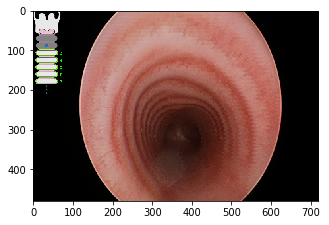

In [ ]:
clear_output()
print ("Starting!")

#For finding posterior region
posterior_region_ctr = 0
prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]
#endof For finding posterior region


#For tracking
tracker=None
#endof For tracking
ctr=0
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    
#     for i in range(0,3):
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break
    
    # Perform inference
    mask = inference(frame)

    # Convert from linear to polar
    polar_image = unwrap_image(mask)

    # Clean up linear image
    clean_img = cv2.erode(polar_image,np.ones((11,1)))
#     clean_flattened_timeline.append((clean_img,(cX,cY)))
    
    #Finding posterior region
    posterior, prev_posterior_angles, posterior_region_ctr = find_posterior_region(clean_img, prev_posterior_angles, posterior_region_ctr)
    mask_continuous = get_posterior_corrected_frame(clean_img, posterior)
    
    #Tracking
    clear_output(wait=True)
    print("ctr {}".format(ctr))
    
    img = mask_continuous==1
    if tracker is None:
        tracker=Tracker(init_frame=img, _verbose=False)
    else:
        success = tracker.iterate(img)
        overlayed_map = draw_trachea_map(frame, [track[-1] for track in tracker.mid_blob_tracks], success)
        pltimg(overlayed_map[...,::-1])
        out.write(overlayed_map)
        #Restart tracker from next frame if tracking is not successful
        if not success: tracker = None

    if DEBUG_MODE:
        #Tests for optimal erosion level
        e_list = []
        for num in range(5,12):
            e = cv2.erode(polar_image,np.ones((num,1)))
            e_list.append(e)
        eroded_timeline.append(e_list)
        
        # Cleaned up linear image
        linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
        clean_timeline.append(linear_image)
    
cap.release()
print ("End!")

In [24]:
out.release()